# Single Orbit Experiment

In [4]:
import sys
sys.path.insert(0, '/home/emmanuel/projects/error_propagation/src')
sys.path.insert(0, '/home/emmanuel/projects/sakame/application/src/')

from single_orbit import SingleOrbitExplore
import numpy as np
# from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster
# import dask.array as da
import xarray as xr

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from showprogress import showprogress

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Parameters

In [5]:
orbits = [
    '20131001120859', 
    '20131001102955',
    '20131001015955',
    '20131001202954',
    '20131001185058',
    '20131001084755',
    '20131001152954',
    '20131001170858',
    '20131001221154', 
    '20131001135058', 
    '20131001034155', 
    '20131001070555', 
    '20131001052355']

day = orbits[0][:8]

## Experimental Parameters

In [110]:
random_state = 123        # for reproducibility
n_components = 50         # number of reduced dimensions for the data
noise_coefficient = 1.0   # Noise coefficient for the likelihood 
input_noise_level = None  # Input Noise Level

n_train_orbits = 1        # number of orbits to take training data from
train_size = 5000         # Number of training points to be used for training

k_folds = 2               # The number of folds for the cross validation grid search
rough_grid = False        # Rough grid search to define the search space
remove_poles = True       # Remove the North and South poles from the data
n_restarts = 0            # Number of restarts for the optimizer

n_test_orbits = 2         # number of orbits to perform testing on

In [101]:
%%time 

single_exp = SingleOrbitExplore(
    random_state=random_state,
    n_components=n_components,
    input_noise_level=input_noise_level, 
    noise_coefficient=noise_coefficient, 
    n_train_orbits=n_train_orbits,
    n_test_orbits=n_test_orbits,
    train_size=train_size,
    rough_grid=rough_grid,
    remove_poles=remove_poles,
    n_restarts=n_restarts, 
    k_folds=k_folds)

data = single_exp.get_data()

Gathering data...
Orbit: 20131001120859
Getting error...
Finding PCA Transformation...
Transformating data...
Splitting into training and testing...
CPU times: user 1min 33s, sys: 1min 8s, total: 2min 42s
Wall time: 17.5 s


## Train GP Model

In [102]:
%%time

single_exp.train_gps(data['xtrain'], data['ytrain'])

Using prev. found starting params...
Starting kernel:
 169**2 * RBF(length_scale=411) + WhiteKernel(noise_level=4.87)
Fitting Standard GP...
Fitted Kernel parameters:...
183**2 * RBF(length_scale=432) + WhiteKernel(noise_level=4.79)
Log Maximum Likelihood: -12450.1286
Training Results...
Fitting Error GP...
Fitted Kernel parameters:...
183**2 * RBF(length_scale=432) + WhiteKernel(noise_level=4.79)
Log Maximum Likelihood: -12450.1358
Training Results...
CPU times: user 12min 32s, sys: 11min 24s, total: 23min 56s
Wall time: 2min 18s


## Test GP Model

In [103]:
%%time

single_exp.test_gps()

Making predictions...
Loading data from orbit 20131001120859
Transforming coordinates...
Saving data...
CPU times: user 11min 2s, sys: 24min 53s, total: 35min 56s
Wall time: 1min 50s


## Save Data

In [104]:
single_exp.xr_dataset

<xarray.Dataset>
Dimensions:       (lat: 359, lon: 527, time: 1)
Coordinates:
  * lon           (lon) float64 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat           (lat) float64 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time          (time) datetime64[ns] 2013-10-01T12:08:59
Data variables:
    temperature   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    predictions   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    epredictions  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    std_dev       (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    estd_dev      (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan

In [105]:
single_exp.models['standard'].kernel_.get_params()['k2__noise_level']

4.7882023333737145

### Remove Bias

In [106]:
bias = single_exp.models['standard'].kernel_.get_params()['k2__noise_level']
print(bias)

4.7882023333737145


## Visualize Labels and Predictions

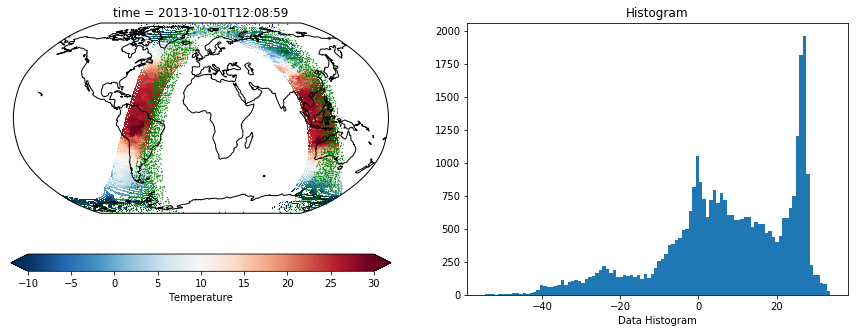

In [113]:
# Temperature
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = single_exp.xr_dataset.temperature.isel(time=0) - 273.15

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmin=-10, vmax=30, cmap='RdBu_r', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Temperature'})

ax1.scatter(data['lon_train'], data['lat_train'], transform=ccrs.PlateCarree(), s=0.1, color='green')

ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

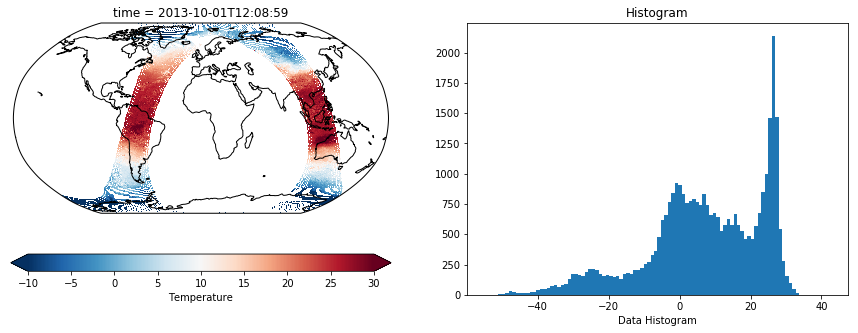

In [97]:
# Predictions
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

data = single_exp.xr_dataset.predictions.isel(time=0) - 273.15
# data = data.sel(lat=slice(-60, 62))

data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmin=-10, vmax=30, cmap='RdBu_r', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Temperature'})
ax1.coastlines()
data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

## Calculate Statistics

In [114]:
def calculate_errors(dataset):
    
    # MEAN ABSOLUTE ERROR
    dataset['error_abs'] = np.abs(dataset['temperature'] - 
                                        dataset['predictions'])
    dataset['eerror_abs'] = np.abs(dataset['temperature'] - 
                                            dataset['epredictions'])
    
#     # MEAN SQUARED ERROR
#     dataset['error_sq'] = np.mean(dataset['temperature'] - 
#                                             dataset['predictions'], axis=0)**2
#     dataset['eerror_sq'] = np.mean(dataset['temperature'] - 
#                                             dataset['epredictions'], axis=0)**2
    # Mean Squared Error (MSE)
    dataset['mse'] = (dataset['temperature'] - 
                                            dataset['predictions'])**2
    dataset['emse'] = (dataset['temperature'] - 
                                            dataset['epredictions'])**2

    # Root Mean Squared Error (RMSE)

    dataset['rmse'] = np.sqrt(dataset['mse'])
    dataset['ermse'] = np.sqrt(dataset['emse'])
#     # ROOT MEAN SQUARED ERROR
#     dataset['error_rmse'] = np.sqrt(dataset['mse'])
#     dataset['eerror_rmse'] = np.sqrt(dataset['emse'])
    
    return dataset

In [115]:
single_exp.xr_dataset = calculate_errors(single_exp.xr_dataset)

In [116]:
single_exp.xr_dataset

<xarray.Dataset>
Dimensions:       (lat: 359, lon: 527, time: 1)
Coordinates:
  * lon           (lon) float64 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat           (lat) float64 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time          (time) datetime64[ns] 2013-10-01T12:08:59
Data variables:
    temperature   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    predictions   (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    epredictions  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    std_dev       (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    estd_dev      (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    error_abs     (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    eerror_abs    (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    mse           (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    emse          (lat, lon, time) float64 nan nan nan nan 

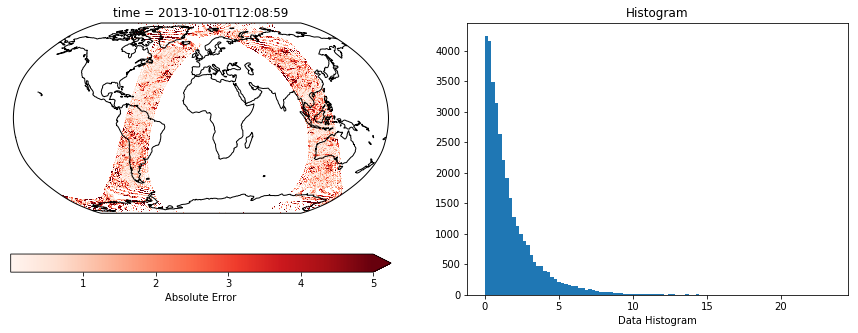

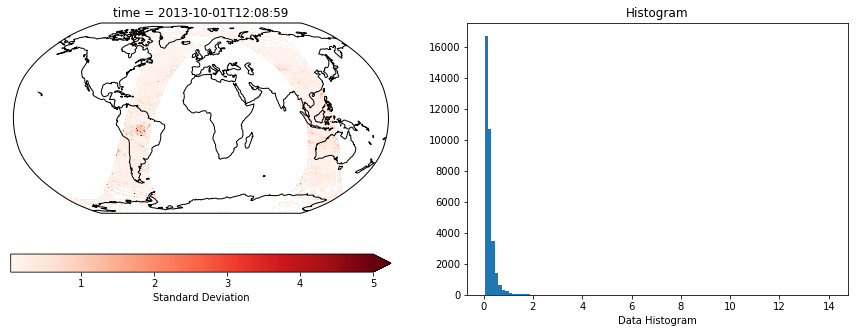

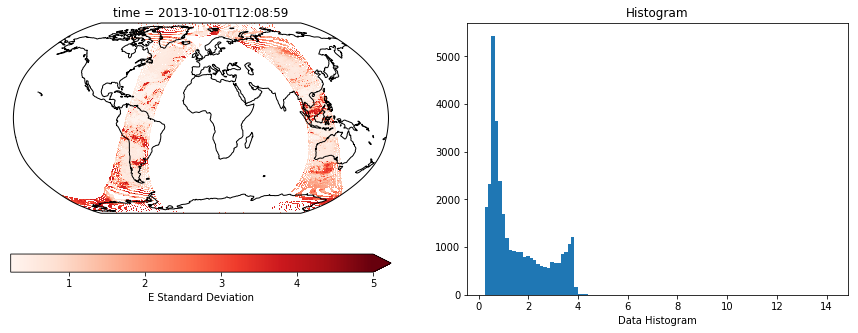

In [125]:
# ========================
# MEAN ABSOLUTE ERROR
# ========================
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = single_exp.xr_dataset.error_abs.isel(time=0)
# data = data.sel(lat=slice(-60, 62))

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmax=5, cmap='Reds', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Absolute Error'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

# ========================
# STANDARD DEVIATION
# ========================
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = single_exp.xr_dataset.std_dev.isel(time=0) - np.sqrt(bias)
# data = data.sel(lat=slice(-60, 62))

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                      vmax=5, cmap='Reds', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Standard Deviation'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

# ========================
# Error STANDARD DEVIATION
# ========================
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)

plot_data = single_exp.xr_dataset.estd_dev.isel(time=0) - np.sqrt(bias)
# data = data.sel(lat=slice(-60, 62))

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(),
                 vmax=5, cmap='Reds', 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'E Standard Deviation'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

## Calculate the Model Error

In [126]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [160]:
def model_error(data, bias=0):
    
    stats = dict()
    # ====================
    # Mean Absolute Error
    # ====================
    
    # Error Values
    std_error = data.error_abs.values[~np.isnan(data.error_abs.values)]
    e_error = data.error_abs.values[~np.isnan(data.eerror_abs.values)]
    
    # Standard deviations
    std_dev = data.std_dev.values[~np.isnan(data.std_dev.values)] - bias
    estd_dev = data.estd_dev.values[~np.isnan(data.estd_dev.values)] - bias
    
    # MAE
    stats['mae'] = mean_absolute_error(std_error, std_dev)
    stats['emae'] = mean_absolute_error(e_error, estd_dev)
    
    # STD MAE
    stats['mae_std'] = np.std(np.abs(std_error - std_dev))
    stats['emae_std'] = np.std(np.abs(e_error - estd_dev))
    
    # ===================
    # Mean Squared Error
    # ===================
    
    # MSE
    stats['mse'] = mean_squared_error(std_error, std_dev)
    stats['emse'] = mean_squared_error(e_error, estd_dev)
    
    # STD MSE
    stats['mse_std'] = np.std((std_error - std_dev)**2)
    stats['emse_std'] = np.std((e_error - estd_dev)**2)
    
    # ========================
    # Root Mean Squared Error
    # ========================
    
    # RMSE
    stats['mse'] = np.sqrt(stats['mse'])
    stats['emse'] = np.sqrt(stats['emse'])
    
    # STD RMSE
    stats['mse_std'] = np.sqrt(stats['mse_std'])
    stats['emse_std'] = np.sqrt(stats['emse_std'])
    
    # =======================
    # R2 Valuee
    # =======================
    
    # MAE
    stats['r2'] = r2_score(std_error, std_dev)
    stats['er2'] = r2_score(e_error, estd_dev)
    

    return stats

In [161]:
stats = model_error(single_exp.xr_dataset, bias=bias)

In [162]:
stats

{'mae': 4.046419055385505,
 'emae': 2.788552038616693,
 'mae_std': 1.808760652439476,
 'emae_std': 1.6092516610351062,
 'mse': 4.4322818355335,
 'emse': 3.2195827960494454,
 'mse_std': 4.8415866474290254,
 'emse_std': 3.906220203824395,
 'r2': -4.940698692640865,
 'er2': -2.134598964742299}